# ECG Library

## Suggested pipeline

### Load ECG images

In [1]:
import os

from PIL import Image
import numpy as np

In [2]:
dirname = 'examples/example_images/'
files = sorted(os.listdir(dirname), key=lambda a: int(a.split('.')[0]))
assert files == list(map(lambda n: f'{n}.png', range(1, 13)))

In [3]:
images = [Image.open(dirname + filename) for filename in files]

### Look at images

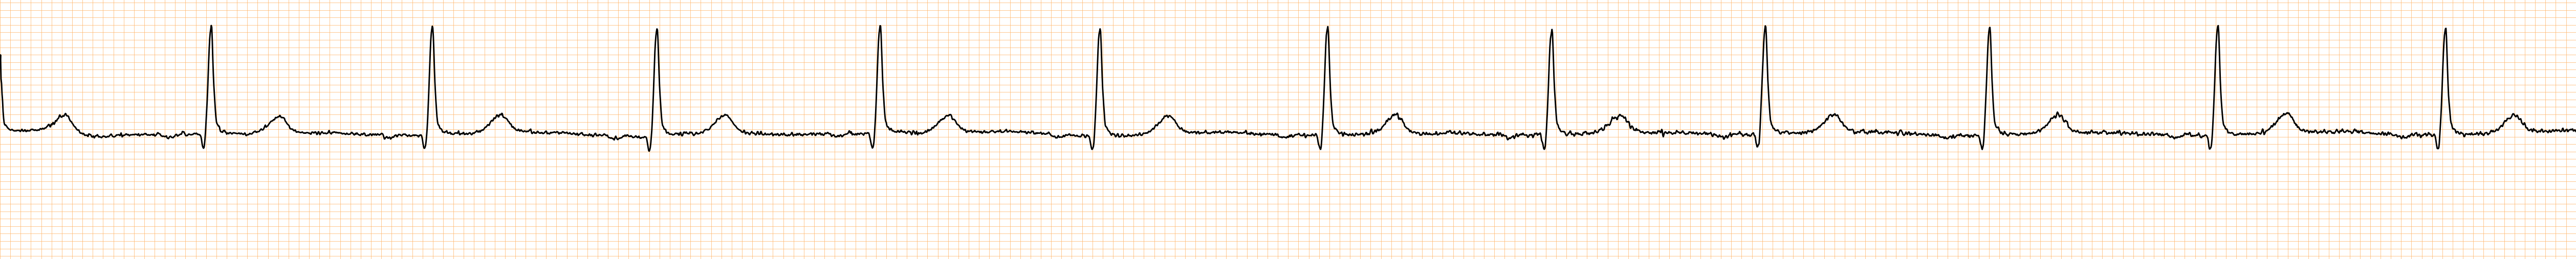

In [4]:
images[1]

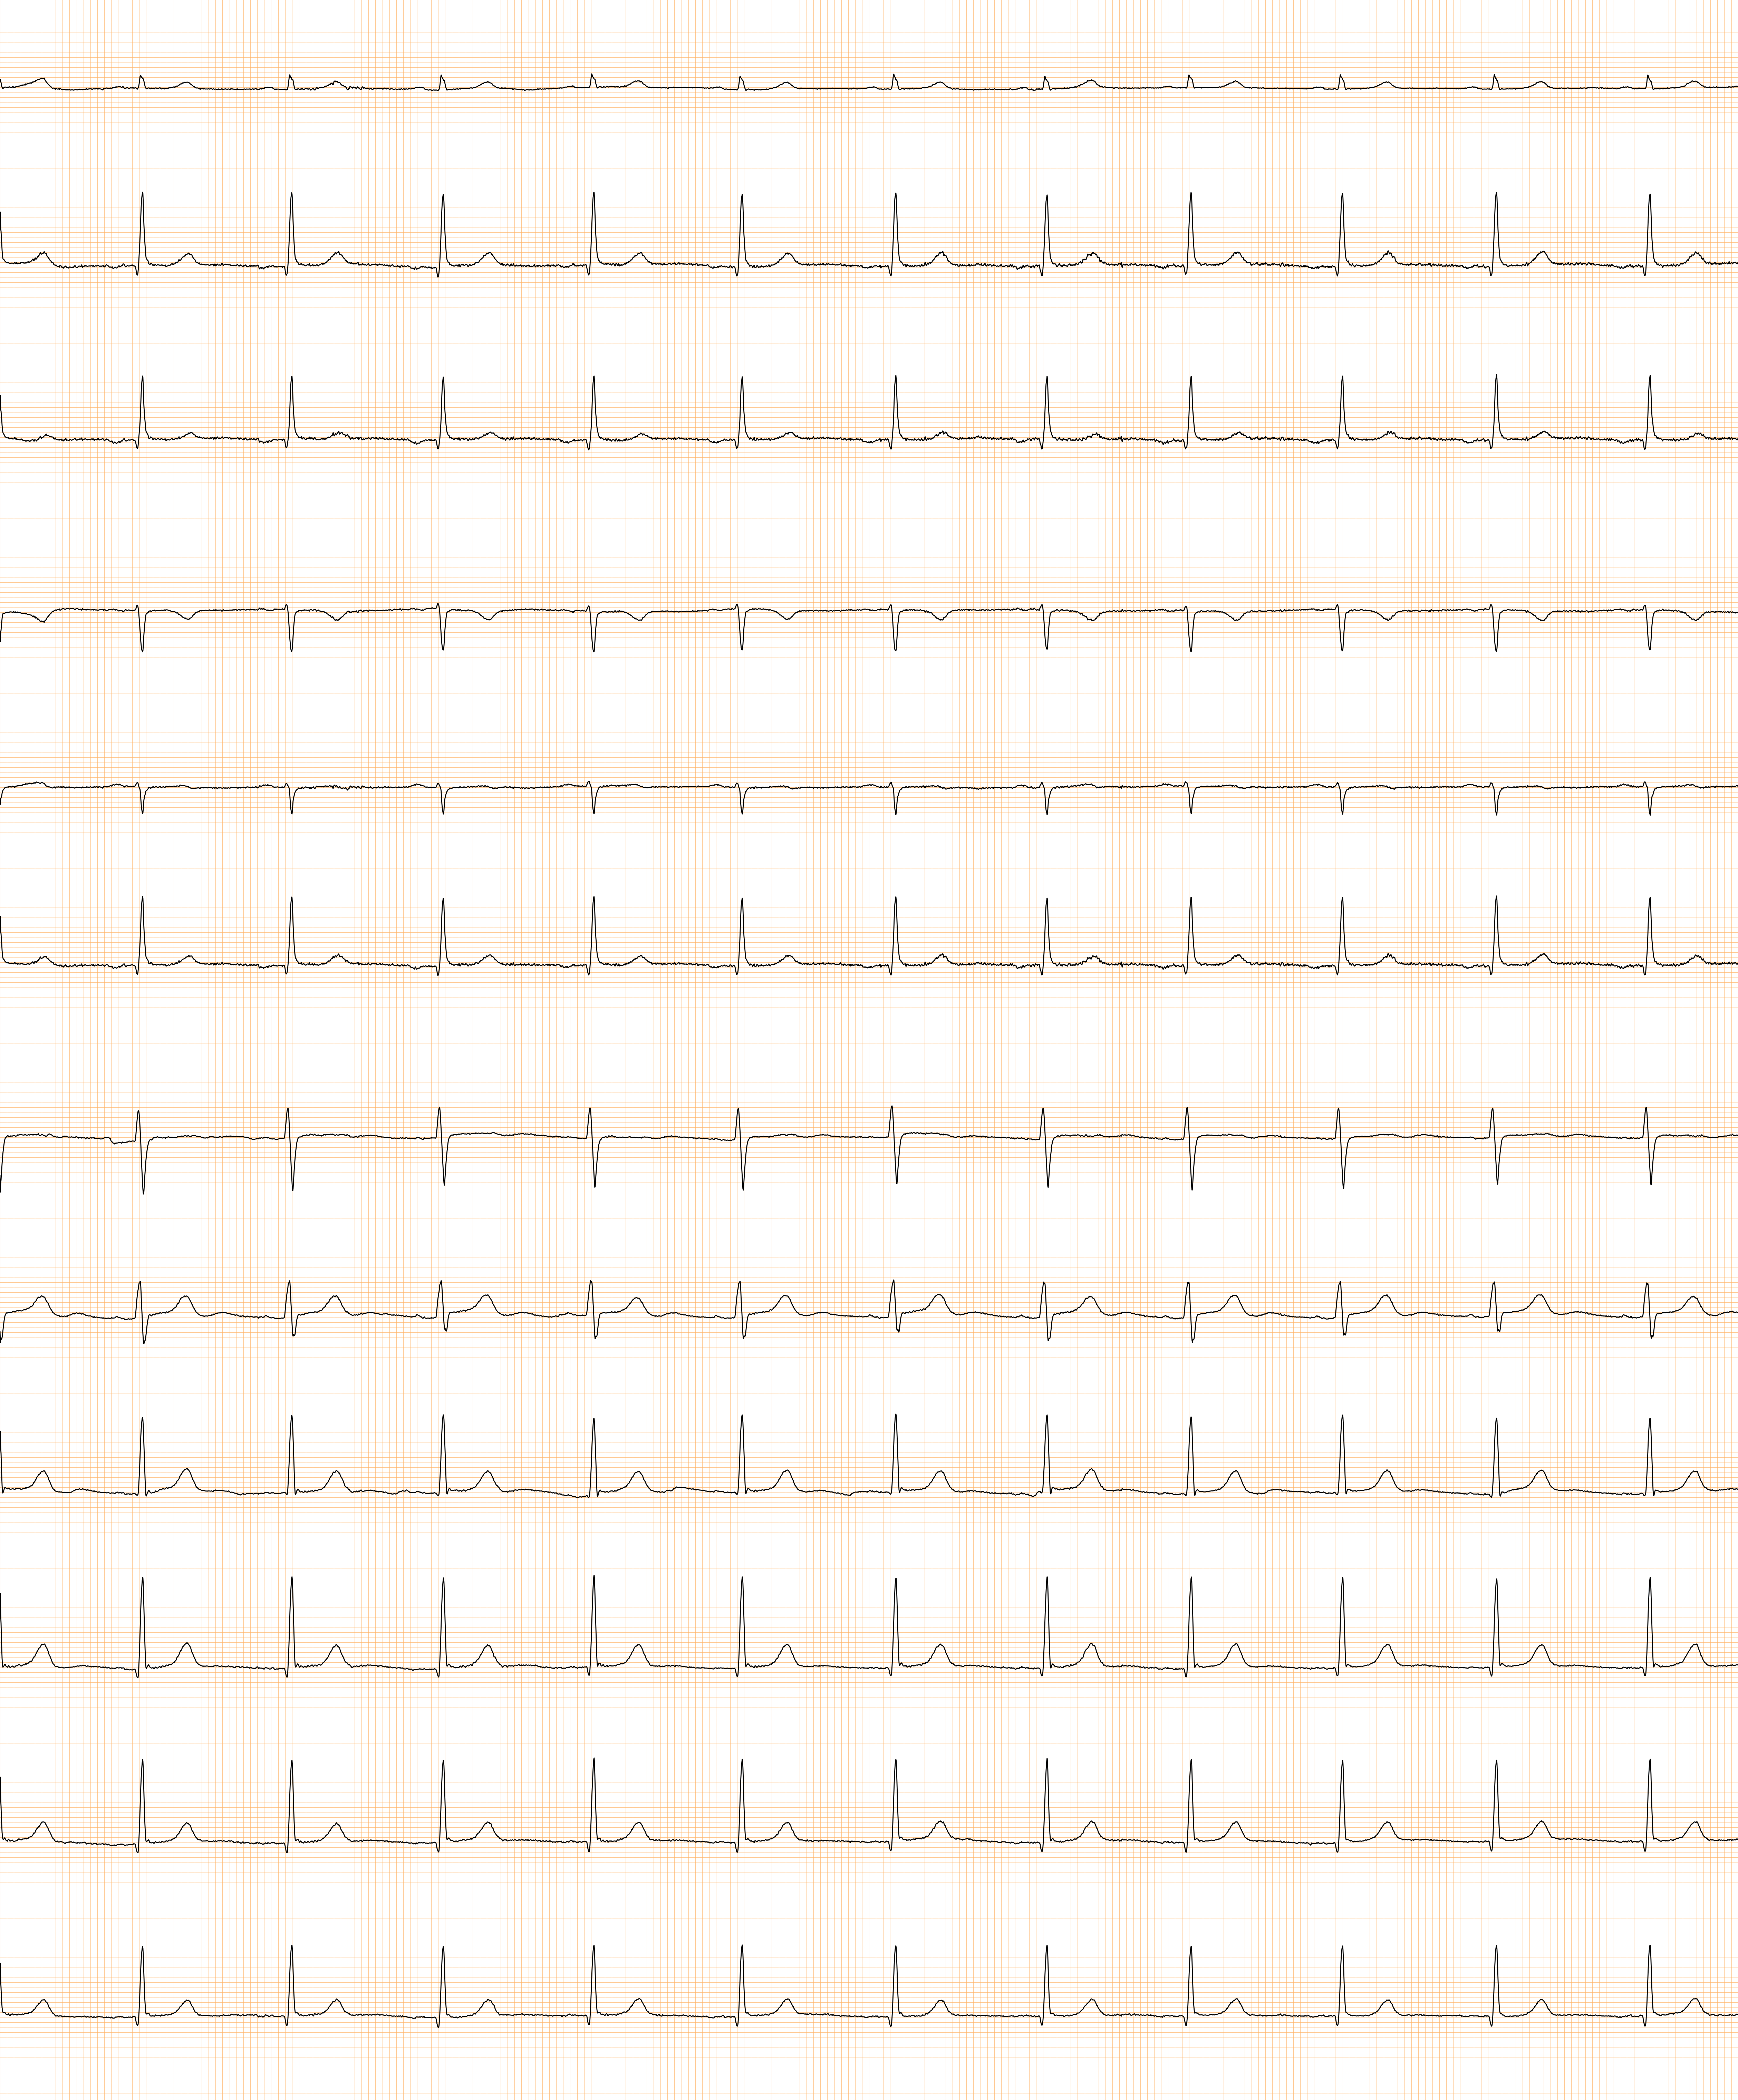

In [5]:
Image.fromarray(np.concatenate(images, axis=0))

### Convert images to signal

In [6]:
import ECG.api as api

In [7]:
import ECG.api as api

In [8]:
signal = [api.convert_image_to_signal(np.asarray(image)[:,:,:3]) for image in images]

### functions for displaying explanations

In [9]:
def display_text_explanation(explanation:api.TextExplanation):
    print('Text explanation:', explanation.content)

def display_text_and_image_explanation(explanation:api.TextAndImageExplanation):
    print('Text explanation:', explanation.text)
    print('GradCAM visualization:')
    return explanation.image

### Get signal of all 12 ECG leads
Recommended sampling rate is 500

In [10]:
sampling_rate = 500

In [11]:
mm_per_mv = 10

In [12]:
signal = np.asarray([s / mm_per_mv for s in signal])

In [13]:
assert len(signal.shape) == 2
assert signal.shape[0] == 12

### Check whether ST-elevation is present

In [14]:
res = api.check_ST_elevation(signal, sampling_rate=sampling_rate)
print('Result:', res[0])
print('Explanation:')
display_text_explanation(res[1])

Result: ElevatedST.Abscent
Explanation:
Text explanation: ST elevation value in lead V3 (0.04126003416910934 mV) did not exceed the threshold 0.2, therefore ST elevation was not detected.


In [15]:
res = api.check_ST_elevation_with_NN(signal)
print('Result:', res[0])
print('Explanation:')
display_text_and_image_explanation(res[1])

Load model at ./ECG/NN_based_approach/Models/Conv1_ste_model.pt
Result: ElevatedST.Abscent
Explanation:
Text explanation: Significant ST elevation probability is 0.3325
GradCAM visualization:


### Evaluate risk markers

In [16]:
api.evaluate_risk_markers(signal, sampling_rate=sampling_rate)

RiskMarkers(Ste60_V3=0.04126003416910934, QTc=419, RA_V4=0.9481276953640756)

### Perform differential diagnosis

In [17]:
res = api.diagnose_with_risk_markers(signal, sampling_rate=sampling_rate)
print('Result:', res[0])
print('Explanation:')
display_text_explanation(res[1])

Result: Diagnosis.BER
Explanation:
Text explanation: Criterion value calculated as follows: (1.196 * [STE60 V3 in mm]) + (0.059 * [QTc in ms]) – (0.326 * [RA V4 in mm])) = 22.123573721775664 did not exceed the threshold 23.4, therefore the diagnosis is Benign Early Repolarization


In [18]:
res = api.check_BER_with_NN(signal)
print('Result:', res[0])
print('Explanation:')
display_text_and_image_explanation(res[1])

Load model at ./ECG/NN_based_approach/Models/Conv_ber_model.pt
Result: True
Explanation:
Text explanation: BER probability is 0.9278
GradCAM visualization:


In [19]:
res = api.check_MI_with_NN(signal)
print('Result:', res[0])
print('Explanation:')
display_text_and_image_explanation(res[1])

Load model at ./ECG/NN_based_approach/Models/Conv_mi_model.pt
Result: False
Explanation:
Text explanation: MI probability is 0.0017
GradCAM visualization:


### Check if the ECG is normal or not

In [20]:
from ECG.api import ECGClass

In [21]:
res = api.check_ecg_is_normal(signal[:, :4000], ECGClass.ALL)
print('Result:', res[0])
display_text_explanation(res[1])

Result: True
Text explanation: The signal is ok


### Get QRS complex

In [22]:
# for better view let's take a shorter signal
short_signal = signal[:, :2000]

In [23]:
cleaned_signal, peaks = api.get_qrs_complex(short_signal, sampling_rate)

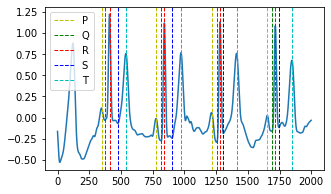

In [24]:
api.show_channel_qrs_complex(cleaned_signal, peaks, 0)

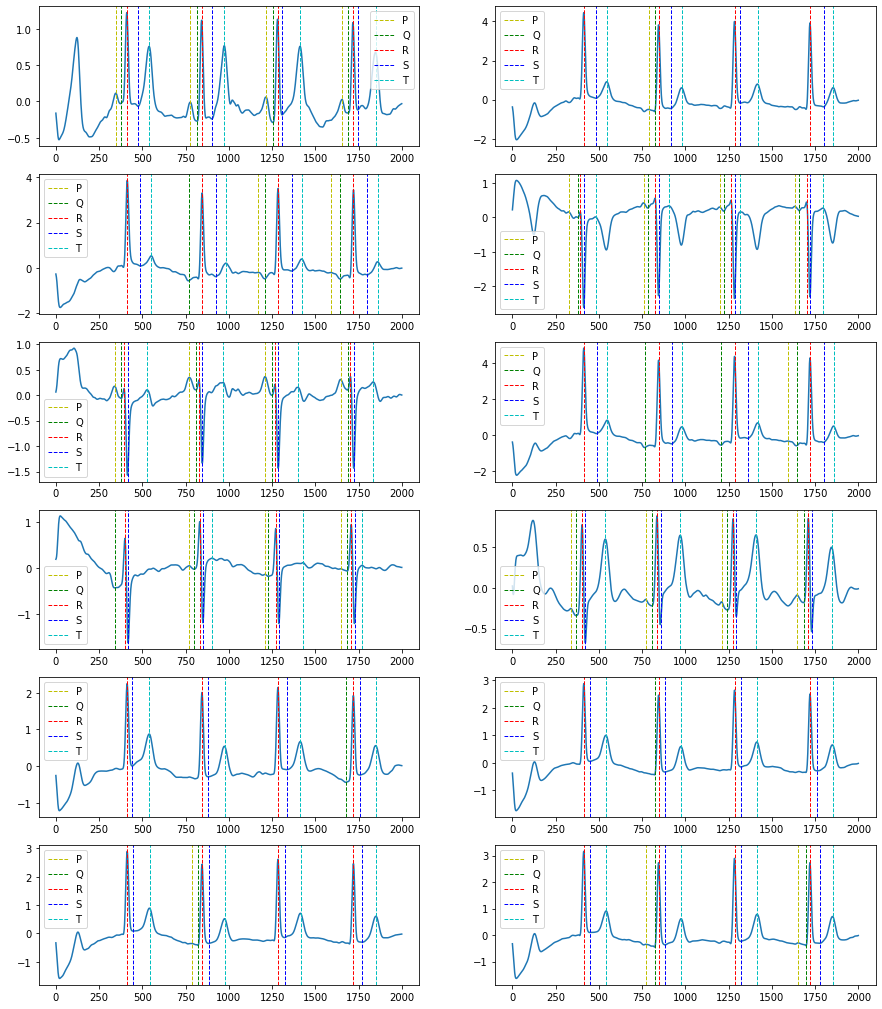

In [25]:
api.show_full_qrs_complex(cleaned_signal, peaks)